This notebook generates tables and graphs to compare ensemble pairs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from knobs_functions import *
import warnings

warnings.filterwarnings('ignore')

In [6]:
my_ensemble_list = ['distpair_ust', 'ust', 'reversible', 'distpair', 'base0', 'county25', 'county50', 'county75', 'county100']

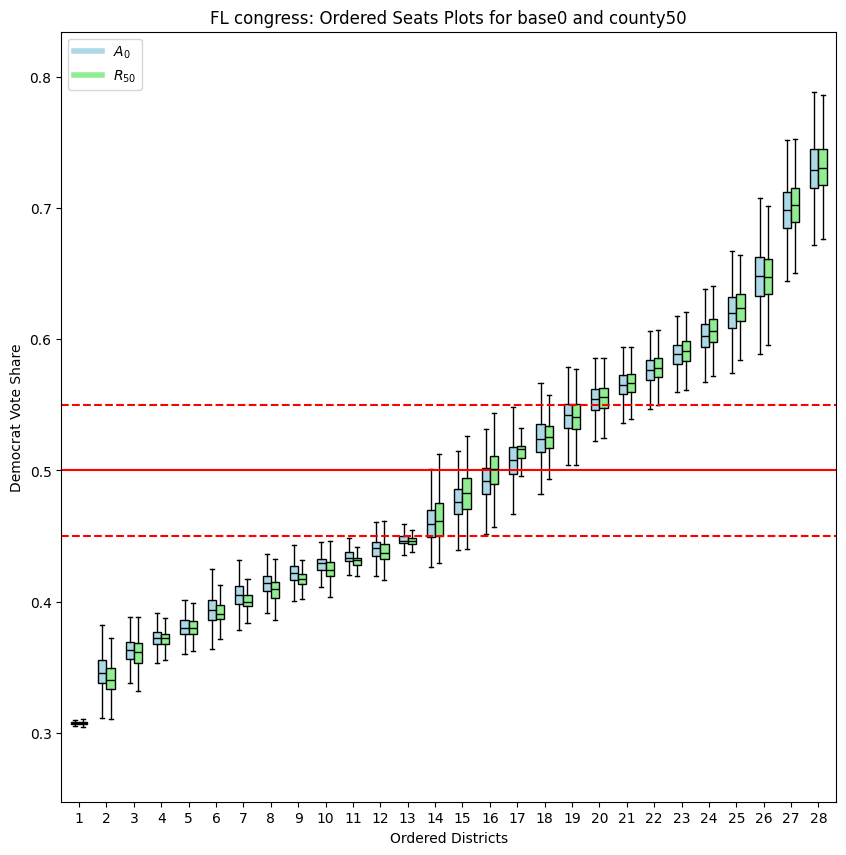

In [25]:
ordered_seats_plot('FL', 'congress', ensemble_list = ['base0', 'county50'],filename='graphs/OSP2.png', competitive_window=1)

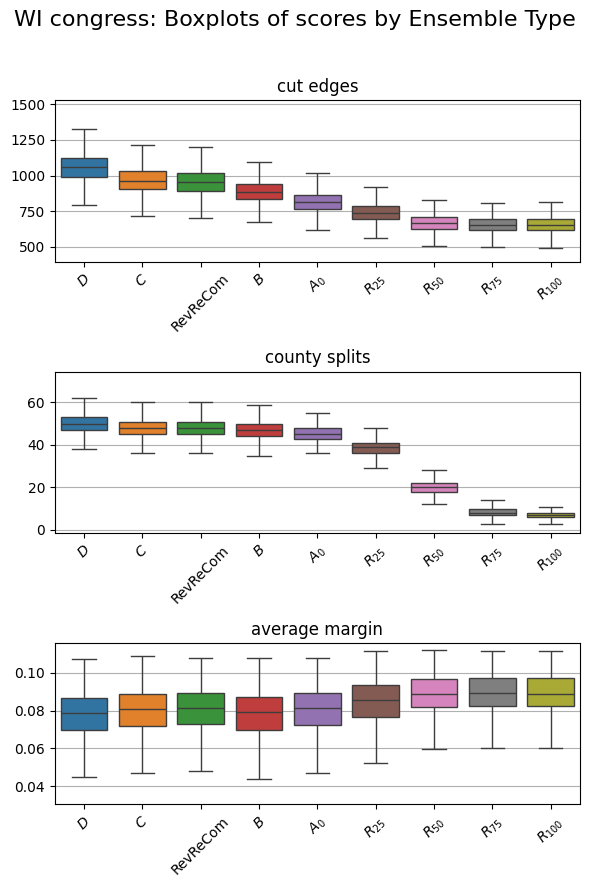

In [7]:
box_whisker_plots_grid('WI', 'congress', my_ensemble_list, score_list=['cut edges', 'county splits', 'average margin'],
                       filename = 'graphs/WI_avg_margin' , cols=1)

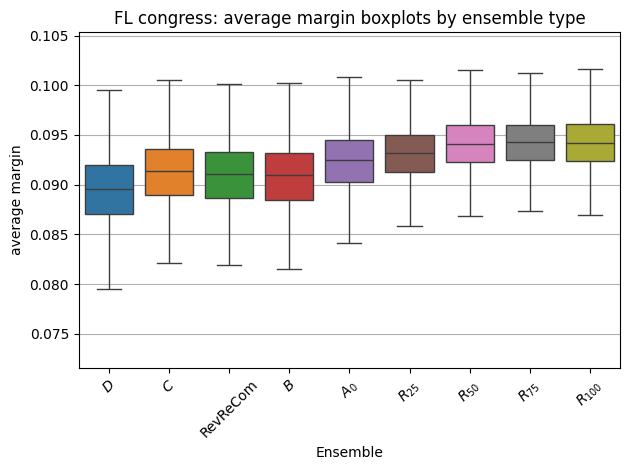

In [8]:
box_whisker_plot('FL', 'congress', my_ensemble_list, 'average margin') # box plot of any given list of ensembles

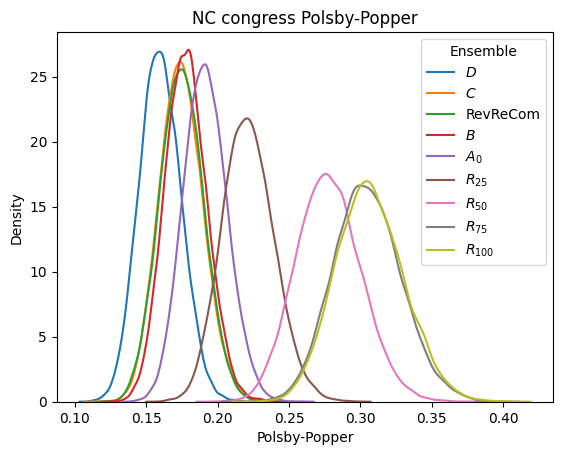

In [9]:
kde_plot('NC', 'congress', my_ensemble_list, 'Polsby-Popper', average_lines=False)

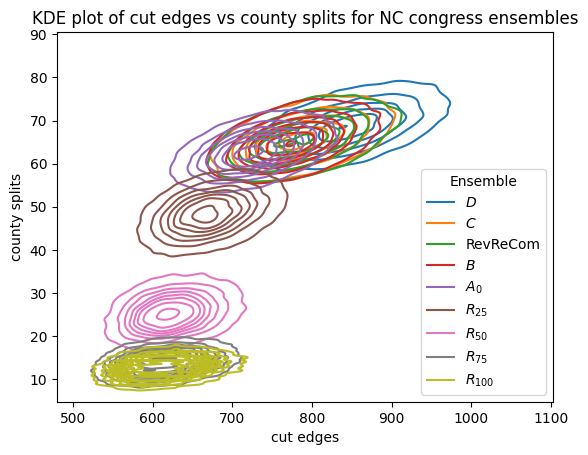

In [10]:
kde_jointplot('NC', 'congress', 'cut edges', 'county splits', my_ensemble_list, filename='graphs/NC_congress_joint_kde.png')

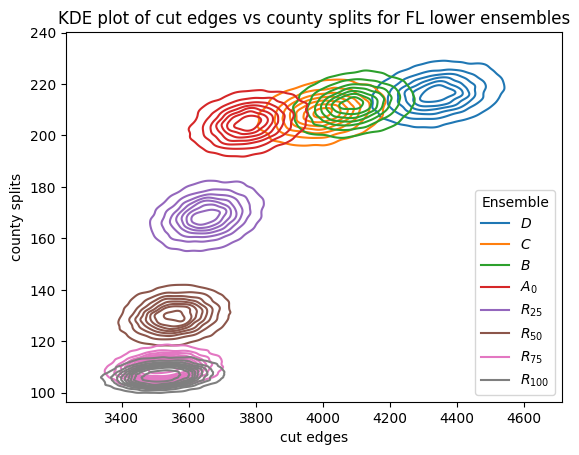

In [15]:
kde_jointplot('FL', 'lower', 'cut edges', 'county splits', my_ensemble_list, filename='graphs/FL_lower_joint_kde.png')

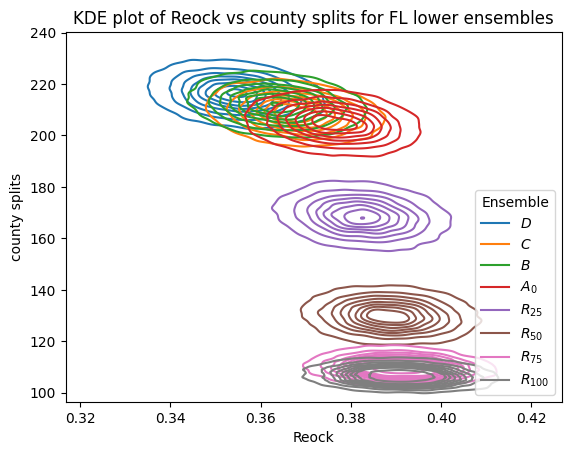

In [19]:
kde_jointplot('FL', 'lower', 'Reock', 'county splits', my_ensemble_list, filename='graphs/FL_lower_joint_Reock_kde.png')

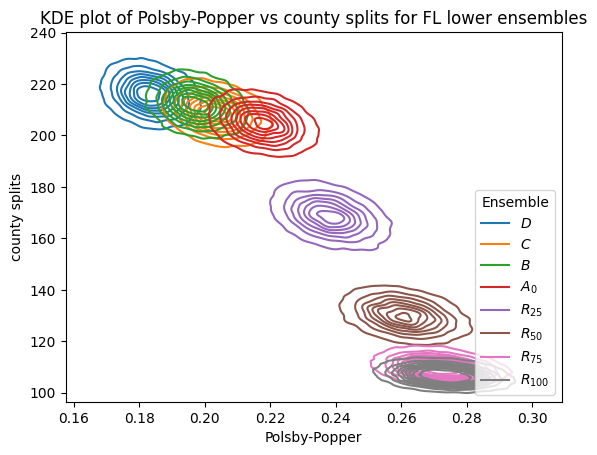

In [20]:
kde_jointplot('FL', 'lower', 'Polsby-Popper', 'county splits', my_ensemble_list, filename='graphs/FL_lower_joint_Reock_kde.png')

In [4]:
# make dictionaries from which later dataframes will be created.
# Each dictionary will map (state, chamber, ensemble, score) to a specific measurement of closeness to the base0 ensemble.

mean_diff_dict = {}
KS_stat_dict = {}
KS_pvalue_dict = {}
T_pvalue_dict = {}
outlier_dict = {}

for state, chamber in state_chamber_list:
    for score in primary_score_list:
        a0 = fetch_score_array(state, chamber, 'base0', score)
        for ensemble in ['base1', 'base2', 'base3', 'base4'] + ensemble_list:
            a1 = fetch_score_array(state, chamber, ensemble, score)
            mean_diff = np.mean(a1) - np.mean(a0)
            KS_stat, KS_pvalue, KS_sign = ks_test(a0, a1)
            KS_signed_stat = KS_stat * KS_sign
            _, T_pvalue = t_test(a1, a0)
            out_dist = outlier_distance(a1, a0)

            outlier_dict[(state, chamber, ensemble, score)] = out_dist
            mean_diff_dict[(state, chamber, ensemble, score)] = mean_diff
            KS_stat_dict[(state, chamber, ensemble, score)] = KS_signed_stat
            KS_pvalue_dict[(state, chamber, ensemble, score)] = KS_pvalue
            T_pvalue_dict[(state, chamber, ensemble, score)] = T_pvalue

Let's measure the mean-difference between scores

In [6]:
def mean_diff_table(score, my_ensemble_list = ['base1']+ ensemble_list, my_state_chamber_list = state_chamber_list, 
                    pvalue = None, latex_filename = None, rounding = 2):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type)
    the mean-difference between that ensemble and the base0 ensemble with respect to the given score.
    If pvalue is set, it will mark values that are significantly different from the base0 ensemble.
    if latex_filename is set, it will also save the dataframe as a latex table.
    """

    index_list = [f'{a[0]} {a[1]}' for a in my_state_chamber_list] + ['AVERAGE']
    df = pd.DataFrame(columns = my_ensemble_list, index = index_list)
    df_mark = df.copy() # True/False signifying whether the value is marked as statistically significant

    for state, chamber in my_state_chamber_list:
        for ensemble in my_ensemble_list:
            mean_diff = mean_diff_dict[(state, chamber, ensemble, score)]
            if score == 'average margin':
                mean_diff = 100 * mean_diff # convert to percentage
            p_value = T_pvalue_dict[(state, chamber, ensemble, score)]
            df.loc[f'{state} {chamber}', ensemble] = mean_diff
            df_mark.loc[f'{state} {chamber}', ensemble] = (pvalue != None and p_value < pvalue)

    df.loc['AVERAGE'] = df.mean()
    df = df.applymap(pd.to_numeric)
    df = df.round(rounding)
    df_latex = df.copy()

    # combine the values and markings into dataframes to return and for Latex
    state_chamber_size_dict = {f'{state} {chamber}': f'{state} {num_seats_dict[(state, chamber)]}' 
                           for state, chamber in my_state_chamber_list}
    for state, chamber in my_state_chamber_list:
        for ensemble in my_ensemble_list:
            if df_mark.loc[f'{state} {chamber}', ensemble]:
                df_latex.loc[f'{state} {chamber}', ensemble] = f'\\textbf{{{df.loc[f"{state} {chamber}", ensemble]}}}'
                df.loc[f'{state} {chamber}', ensemble] = f'*{df.loc[f"{state} {chamber}", ensemble]}'

    if latex_filename is not None:
        df_latex.rename(columns=ensemble_name_dict, index=state_chamber_size_dict, inplace=True)
        df_latex.to_latex(latex_filename, escape=False)
    return df

In [10]:
my_ensemble_list = ['base1'] + [x for x in ensemble_list if x != 'reversible']

In [11]:
ds_Dem = mean_diff_table('Dem seats', my_ensemble_list, pvalue=.001, latex_filename='latex tables/mean_diff_table.tex')
ds_Dem

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.00,0.01,0.00,*-0.18,*-0.11,*-0.29,*0.42,*0.59,*0.56,*0.55
FL upper,0.02,-0.01,0.02,*-0.09,-0.02,*-0.14,*0.07,0.04,*0.05,*0.1
FL lower,0.01,0.03,0.03,0.01,-0.0,-0.06,*-0.12,*-0.21,*-0.09,*0.07
IL congress,0.00,-0.01,-0.00,*0.03,0.01,*0.04,*-0.06,*-0.23,*-0.23,*-0.21
IL upper,-0.01,-0.03,0.04,-0.01,*0.1,*0.09,-0.03,0.0,*-0.07,*-0.15
IL lower,0.01,0.03,0.00,-0.05,*0.08,0.01,*-0.14,*-0.14,*-0.22,*-0.35
MI congress,-0.00,0.0,0.00,*0.05,*0.06,*0.09,*-0.04,*-0.16,*-0.26,*-0.27
MI upper,-0.01,-0.0,-0.03,*0.07,0.03,*0.18,0.01,*0.11,*0.13,*0.14
MI lower,-0.03,-0.02,0.01,0.03,-0.06,0.04,*0.23,*0.46,*0.53,*0.48
NC congress,0.01,0.01,-0.00,*-0.03,*-0.05,*-0.08,*-0.04,*-0.07,*-0.08,*-0.09


In [12]:
ds_EG = mean_diff_table('efficiency gap', my_ensemble_list, pvalue=.001)
ds_EG

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,-0.0,-0.0,-0.0,*0.01,*0.0,*0.01,*-0.02,*-0.02,*-0.02,*-0.02
FL upper,-0.0,0.0,-0.0,*0.0,0.0,*0.0,*-0.0,-0.0,-0.0,*-0.0
FL lower,-0.0,-0.0,-0.0,-0.0,0.0,0.0,*0.0,*0.0,*0.0,-0.0
IL congress,-0.0,0.0,0.0,*-0.0,-0.0,*-0.0,*0.0,*0.01,*0.01,*0.01
IL upper,0.0,0.0,*-0.0,0.0,*-0.0,*-0.0,0.0,-0.0,*0.0,*0.0
IL lower,-0.0,-0.0,-0.0,-0.0,*-0.0,*-0.0,*0.0,*0.0,*0.0,*0.0
MI congress,0.0,-0.0,-0.0,*-0.0,*-0.0,*-0.01,*0.0,*0.01,*0.02,*0.02
MI upper,0.0,0.0,0.0,*-0.0,-0.0,*-0.0,-0.0,*-0.0,*-0.0,*-0.01
MI lower,0.0,0.0,-0.0,-0.0,0.0,-0.0,*-0.0,*-0.01,*-0.01,*-0.01
NC congress,-0.0,-0.0,0.0,0.0,*0.0,*0.0,0.0,*0.0,*0.0,*0.0


In [7]:
ds_am = mean_diff_table('average margin', my_ensemble_list, pvalue=.001, latex_filename='latex tables/mean_diff_table_am.tex', rounding=2)
ds_am

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.01,0.01,-0.0,*-0.15,*-0.11,*-0.29,*0.08,*0.17,*0.19,*0.19
FL upper,0.00,-0.01,*0.02,*-0.05,*-0.04,*-0.11,*0.05,*0.09,*0.08,*0.08
FL lower,0.00,*-0.01,*0.01,*-0.08,*-0.05,*-0.13,*0.03,*0.07,*0.1,*0.1
IL congress,0.00,0.0,-0.0,*-0.02,*0.01,*-0.02,*-0.01,*0.06,*0.11,*0.12
IL upper,0.00,-0.0,0.0,*-0.07,*-0.04,*-0.12,*0.04,*0.09,*0.1,*0.1
IL lower,-0.00,0.0,0.0,*-0.07,*-0.03,*-0.1,*0.01,*0.01,*-0.01,*-0.02
MI congress,0.00,0.0,-0.0,*-0.03,-0.01,*-0.03,0.01,*0.02,*0.04,*0.05
MI upper,0.00,0.01,-0.0,*-0.15,*-0.05,*-0.23,*0.09,*0.2,*0.23,*0.22
MI lower,-0.00,0.0,-0.0,*-0.06,*-0.04,*-0.11,-0.0,*0.01,*0.01,*0.01
NC congress,0.00,0.0,0.0,-0.01,*-0.06,*-0.1,*0.07,*0.2,*0.27,*0.28


In [8]:
ds_competitive = mean_diff_table('competitive districts', my_ensemble_list, pvalue=.001 ,latex_filename='latex tables/competitive_table.tex')
ds_competitive

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,-0.02,-0.04,-0.01,*0.46,*0.3,*0.88,-0.03,*-0.09,*-0.11,*-0.1
FL upper,-0.02,-0.02,*-0.06,0.03,0.05,*0.16,*-0.14,*-0.31,*-0.37,*-0.43
FL lower,0.05,0.09,-0.0,*0.11,*0.14,*0.19,*0.45,*0.39,*0.28,*0.44
IL congress,-0.00,-0.02,-0.01,*0.04,0.02,*0.06,*-0.16,0.01,*0.06,*0.05
IL upper,-0.04,*-0.12,*0.1,*0.08,*0.07,*0.21,*-0.07,*0.13,*0.26,*0.37
IL lower,0.00,-0.02,0.05,*0.25,*0.1,*0.34,*0.23,*0.78,*1.43,*1.65
MI congress,0.00,-0.01,-0.0,*-0.07,*-0.06,*-0.15,0.01,*0.07,*0.12,*0.1
MI upper,-0.02,0.03,-0.04,*0.35,0.01,*0.43,*-0.1,*-0.08,*-0.07,-0.06
MI lower,0.02,-0.02,-0.03,-0.08,-0.07,-0.08,*0.34,*0.63,*0.76,*0.76
NC congress,-0.01,0.0,0.01,-0.01,*0.05,0.04,0.0,*-0.08,*-0.14,*-0.16


In [9]:
# Look at which state-chamber pairs have nonnegligible numbers of MMD districts

MMD_table = pd.DataFrame(columns = [f'{a[0]} {a[1]}' for a in state_chamber_list],
                          index = ['MMD black', 'MMD hispanic', 'MMD coalition'])
for state, chamber in state_chamber_list:
    a_black = fetch_score_array(state, chamber, 'base0', 'MMD black')
    a_hispanic = fetch_score_array(state, chamber, 'base0', 'MMD hispanic') 
    a_coalition = fetch_score_array(state, chamber, 'base0', 'MMD coalition')
    MMD_table.loc['MMD black', f'{state} {chamber}'] = np.mean(a_black)
    MMD_table.loc['MMD hispanic', f'{state} {chamber}'] = np.mean(a_hispanic)  
    MMD_table.loc['MMD coalition', f'{state} {chamber}'] = np.mean(a_coalition)

In [10]:
pd.set_option('display.max_columns', None)  # Show all columns
MMD_table

,FL congress,FL upper,FL lower,IL congress,IL upper,IL lower,MI congress,MI upper,MI lower,NC congress,NC upper,NC lower,NY congress,NY upper,NY lower,OH congress,OH upper,OH lower,WI congress,WI upper,WI lower
MMD black,0.0,0.02785,3.09885,0.91445,4.5948,10.2013,0.42885,2.5922,7.88535,0.0,1.20775,6.94535,0.6657,3.2929,10.09995,0.0,0.47305,3.65895,0.0,0.7259,3.3222
MMD hispanic,2.97625,4.38375,13.17785,0.00015,1.1666,3.81975,0.0,0.0,0.0,0.0,0.0,0.0,1.0125,3.33445,9.2593,0.0,0.0,0.0,0.0,0.0,0.4307
MMD coalition,6.0933,8.8823,30.40865,2.4913,9.55955,20.3114,0.6124,2.92205,8.82975,0.0053,2.90655,12.8237,5.3738,13.4796,34.535,0.00015,0.7003,4.474,0.0,1.07035,4.7256


In [11]:
# Make a list of state-chambers with at least 1 MMD on average

SC_black = [] #state-chambers with at least 1 black MMD on average
SC_hispanic = [] #state-chambers with at least 1 hispanic MMD on average
SC_coalition = [] #state-chambers with at least 1 coalition MMD on average
for state, chamber in state_chamber_list:
    a_black = fetch_score_array(state, chamber, 'base0', 'MMD black')
    a_hispanic = fetch_score_array(state, chamber, 'base0', 'MMD hispanic') 
    a_coalition = fetch_score_array(state, chamber, 'base0', 'MMD coalition')
    if np.mean(a_black) > 1:
        SC_black.append((state, chamber))
    if np.mean(a_hispanic) > 1:
        SC_hispanic.append((state, chamber))
    if np.mean(a_coalition) > 1:
        SC_coalition.append((state, chamber))

In [12]:
len(SC_black), len(SC_hispanic), len(SC_coalition)

(11, 8, 16)

In [13]:
dsb = mean_diff_table('MMD black', my_ensemble_list, pvalue=.001, my_state_chamber_list=SC_black,
                      latex_filename='latex tables/MMD_Black_table.tex')
dsb

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL lower,-0.00,-0.01,0.01,*-0.17,*-0.1,*-0.28,*-0.05,*-0.13,*-0.17,*-0.17
IL upper,-0.00,-0.02,0.01,*-0.12,*-0.04,*-0.17,*0.06,*0.12,*0.15,*0.15
IL lower,0.01,-0.03,0.00,*-0.11,*-0.05,*-0.15,*0.08,*0.21,*0.34,*0.4
MI upper,-0.01,-0.00,-0.00,*-0.08,*-0.06,*-0.13,*-0.03,*-0.07,*-0.06,*-0.06
MI lower,0.01,-0.00,0.00,*-0.06,-0.01,*-0.05,*-0.07,*-0.14,*-0.15,*-0.17
NC upper,0.01,0.02,0.01,*-0.08,*-0.04,*-0.13,*0.06,*0.13,*0.15,*0.15
NC lower,0.00,0.02,0.03,*-0.2,*-0.12,*-0.36,*0.06,*0.13,*0.17,*0.17
NY upper,-0.01,-0.01,-0.02,*-0.12,*-0.08,*-0.2,*0.09,*0.31,*0.4,*0.4
NY lower,-0.01,-0.01,-0.01,*-0.18,*-0.12,*-0.28,*0.05,*0.08,*0.12,*0.25
OH lower,0.01,0.01,0.01,*-0.25,*-0.2,*-0.44,-0.02,-0.03,*-0.06,*-0.06


In [14]:
dsh = mean_diff_table('MMD hispanic', my_ensemble_list, pvalue=.001, my_state_chamber_list=SC_hispanic,
                      latex_filename='latex tables/MMD_hispanic_table.tex')
dsh

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,-0.00,0.0,0.00,*-0.07,*-0.02,*-0.1,*0.02,*0.04,*0.04,*0.04
FL upper,0.01,0.01,0.02,*-0.11,*-0.03,*-0.16,*-0.13,*-0.29,*-0.33,*-0.36
FL lower,-0.00,*-0.04,-0.01,*-0.07,*-0.04,*-0.09,*-0.09,*-0.11,*-0.03,*-0.05
IL upper,-0.01,-0.01,-0.01,*-0.05,*-0.03,*-0.07,-0.01,-0.01,0.0,-0.0
IL lower,-0.01,-0.0,-0.01,*-0.07,-0.03,*-0.12,0.02,0.01,0.0,-0.01
NY congress,0.00,0.01,0.00,*-0.05,*-0.02,*-0.08,*0.13,*0.23,*0.23,*0.23
NY upper,-0.01,-0.0,0.02,*-0.13,*-0.08,*-0.22,*0.03,-0.0,*0.05,*0.09
NY lower,0.01,-0.02,0.01,*-0.13,*-0.03,*-0.18,*0.03,*-0.04,*-0.07,*-0.04
AVERAGE,-0.00,-0.01,0.00,-0.08,-0.04,-0.13,0.0,-0.02,-0.01,-0.01


In [15]:
dsc = mean_diff_table('MMD coalition', my_ensemble_list, pvalue=.001, my_state_chamber_list=SC_coalition,
                      latex_filename='latex tables/MMD_coalition_table.tex')
dsc

,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.01,0.02,0.01,*-0.09,*-0.07,*-0.19,*0.06,*0.17,*0.18,*0.18
FL upper,-0.01,-0.02,0.03,*-0.08,*-0.03,*-0.15,*0.07,*0.22,*0.22,*0.18
FL lower,0.02,0.02,0.03,*-0.25,*-0.14,*-0.4,0.01,-0.02,0.03,*0.08
IL congress,0.00,-0.00,0.01,-0.01,*0.05,0.02,*0.05,*0.17,*0.19,*0.19
IL upper,-0.01,-0.02,-0.01,*-0.05,-0.02,*-0.08,*0.08,*0.17,*0.19,*0.19
IL lower,-0.00,-0.01,-0.01,*-0.11,-0.04,*-0.17,*0.28,*0.54,*0.64,*0.65
MI upper,-0.01,-0.01,-0.0,*-0.08,*-0.06,*-0.13,*-0.06,*-0.15,*-0.16,*-0.16
MI lower,0.01,0.02,0.01,*-0.08,-0.03,*-0.11,*-0.11,*-0.22,*-0.24,*-0.25
NC upper,-0.00,-0.00,0.0,*-0.15,*-0.09,*-0.28,*0.19,*0.44,*0.56,*0.57
NC lower,0.03,0.00,*0.06,*-0.32,*-0.18,*-0.56,*0.21,*0.33,*0.39,*0.41


In [59]:
ds3 = mean_diff_table('average margin', my_ensemble_list, pvalue=.001, rounding = 4, latex_filename='latex tables/avg_margin_table.tex')
ds3

C:\Users\ktapp\AppData\Local\Temp\ipykernel_33920\2057152442.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_latex.to_latex(latex_filename, escape=False)


,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.0001,0.0001,-0.0,*-0.0015,*-0.0011,*-0.0029,*0.0008,*0.0017,*0.0019,*0.0019
FL upper,0.0,-0.0001,*0.0002,*-0.0005,*-0.0004,*-0.0011,*0.0005,*0.0009,*0.0008,*0.0008
FL lower,0.0,*-0.0001,*0.0001,*-0.0008,*-0.0005,*-0.0013,*0.0003,*0.0007,*0.001,*0.001
IL congress,0.0,0.0,-0.0,*-0.0002,*0.0001,*-0.0002,*-0.0001,*0.0006,*0.0011,*0.0012
IL upper,0.0,-0.0,0.0,*-0.0007,*-0.0004,*-0.0012,*0.0004,*0.0009,*0.001,*0.001
IL lower,-0.0,0.0,0.0,*-0.0007,*-0.0003,*-0.001,*0.0001,*0.0001,*-0.0001,*-0.0002
MI congress,0.0,0.0,-0.0,*-0.0003,-0.0001,*-0.0003,0.0001,*0.0002,*0.0004,*0.0005
MI upper,0.0,0.0001,-0.0,*-0.0015,*-0.0005,*-0.0023,*0.0009,*0.002,*0.0023,*0.0022
MI lower,-0.0,0.0,-0.0,*-0.0006,*-0.0004,*-0.0011,-0.0,*0.0001,*0.0001,*0.0001
NC congress,0.0,0.0,0.0,-0.0001,*-0.0006,*-0.001,*0.0007,*0.002,*0.0027,*0.0028


Now let's measure how close the ordered-seats-plots are to the base ensemble.

In [29]:
# Add more dictionaries corresponding to the distance between orderd-seats plots.
# Each dictionary will map (state, chamber, ensemble) to a measurement of closeness to the base0 ensemble.
# The measurement is the (max/mean) over the ordered seats of the ks-distance for that seat between the base0 ensemble and the ensemble in question. 
# We consider ALL ordered seats or just the COMPEITIVE ones.

OSP_all_max = {}
OSP_all_mean = {}
OSP_competitive_max = {}
OPS_competitive_mean = {}
OSP_num_competitive = {}

for state, chamber in state_chamber_list:
    X0 = fetch_score_array(state, chamber, 'base0', 'by_district')
    for ensemble in ['base1', 'base2', 'base3', 'base4'] + ensemble_list:
        X1 = fetch_score_array(state, chamber, ensemble, 'by_district')
        num_seats = X0.shape[1]
        ls = []
        ls_comp = []
        for i in range(num_seats):
            closeness = ks_test(X1[:, i], X0[:, i])[0]
            ls.append(closeness)
            if abs(np.mean(X0[:, i]) - 0.5) < .05 or abs(np.mean(X1[:, i]) - 0.5) < .05:
                ls_comp.append(closeness)
        OSP_all_max[(state, chamber, ensemble)] = np.max(ls)
        OSP_all_mean[(state, chamber, ensemble)] = np.mean(ls)
        OSP_competitive_max[(state, chamber, ensemble)] = np.max(ls_comp)
        OPS_competitive_mean[(state, chamber, ensemble)] = np.mean(ls_comp)
        OSP_num_competitive[(state, chamber, ensemble)] = len(ls_comp)

In [32]:
def Ordered_seats_table(my_ensemble_list = ['base1']+ ensemble_list, combine_method = 'max', seats = 'competitive', rounding = 2, latex_filename = None):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the "distance" between the ordered seats plots of the ensemble and the base0 ensemble.
    It sums or averages the ks-distance between the ordered seats.
    If seats == 'competitive', it only considers seats that are competitive for at least one of the two ensembles being compared.
    """
    index_list = [f'{a[0]} {a[1]}' for a in state_chamber_list] + ['AVERAGE']
    df = pd.DataFrame(columns = my_ensemble_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in my_ensemble_list:
            if seats == 'all':
                if combine_method == 'max':
                    closeness = OSP_all_max[(state, chamber, ensemble)]
                elif combine_method == 'mean':
                    closeness = OSP_all_mean[(state, chamber, ensemble)]
            elif seats == 'competitive':
                if combine_method == 'max':
                    closeness = OSP_competitive_max[(state, chamber, ensemble)]
                elif combine_method == 'mean':
                    closeness = OPS_competitive_mean[(state, chamber, ensemble)]
            df.loc[f'{state} {chamber}', ensemble] = closeness
    df = df.apply(pd.to_numeric)
    df.loc['AVERAGE'] = df.iloc[:-1].mean()
    df = df.round(rounding)

    if latex_filename is not None:
        state_chamber_size_dict = {f'{state} {chamber}': f'{state} {num_seats_dict[(state, chamber)]}' 
                           for state, chamber in state_chamber_list}
        df_latex = df.copy()
        df_latex.rename(columns=ensemble_name_dict, index = state_chamber_size_dict, inplace=True)
        df_latex.to_latex(latex_filename, escape=False)
    return df

In [33]:
Ordered_seats_table(my_ensemble_list, 'max', 'competitive', latex_filename='latex tables/OSP.tex')

C:\Users\ktapp\AppData\Local\Temp\ipykernel_33920\3337259921.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_latex.to_latex(latex_filename, escape=False)


,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.02,0.02,0.02,0.13,0.09,0.24,0.18,0.30,0.30,0.29
FL upper,0.02,0.04,0.07,0.04,0.02,0.07,0.06,0.11,0.13,0.16
FL lower,0.01,0.03,0.01,0.03,0.03,0.05,0.07,0.09,0.09,0.09
IL congress,0.01,0.01,0.01,0.04,0.07,0.06,0.09,0.21,0.25,0.25
IL upper,0.01,0.02,0.03,0.03,0.04,0.07,0.05,0.13,0.17,0.20
IL lower,0.01,0.02,0.02,0.03,0.04,0.07,0.04,0.13,0.22,0.26
MI congress,0.01,0.01,0.01,0.07,0.09,0.15,0.04,0.15,0.21,0.22
MI upper,0.01,0.03,0.05,0.08,0.02,0.14,0.04,0.10,0.13,0.14
MI lower,0.01,0.02,0.02,0.04,0.02,0.04,0.08,0.19,0.25,0.26
NC congress,0.01,0.01,0.03,0.03,0.03,0.07,0.03,0.08,0.12,0.12


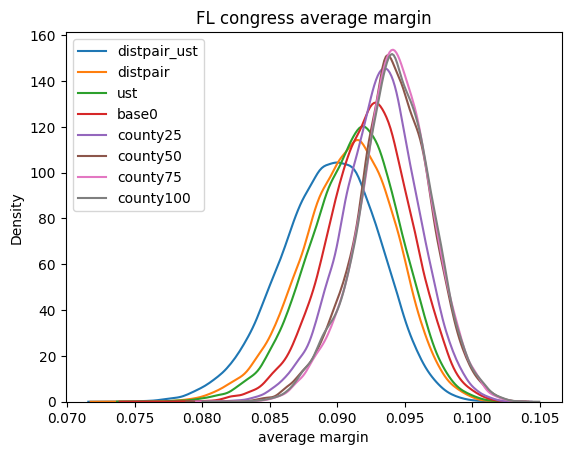

In [30]:
state = 'FL' 
chamber = 'congress'
score = 'average margin'
my_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'base0', 'county25', 'county50', 'county75', 'county100']
kde_plot(state, chamber, my_ensemble_list, score, average_lines=False, filename='graphs/FL_cong_avg_margin_kde_plot.png')

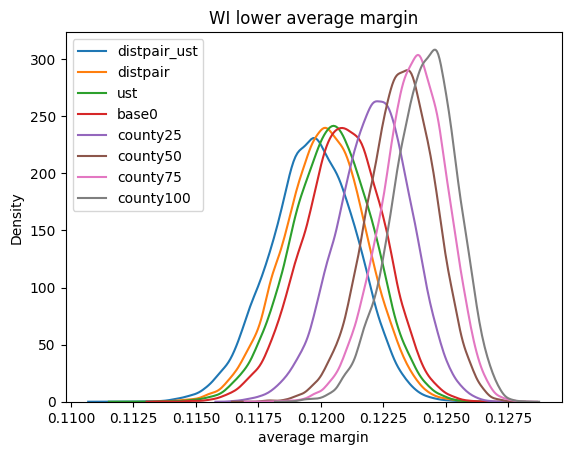

In [22]:
state = 'WI' 
chamber = 'lower'
score = 'average margin'
my_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'base0', 'county25', 'county50', 'county75', 'county100']
kde_plot(state, chamber, my_ensemble_list, score, average_lines=False, filename='graphs/WI_lower_avg_margin_kde_plot.png')

In [37]:
# print the order of the averages of the above histograms
score = 'average margin'
#my_ensemble_list = ['distpair_ust', 'ust', 'base0', 'county25', 'county25', 'county75']
for state, chamber in state_chamber_list:
    mean_dict = dict()
    for ensemble in ensemble_list+['base0']:
        a = fetch_score_array(state, chamber, ensemble, score)
        mean_dict[ensemble] = np.mean(a)
    l = sorted(mean_dict,key=mean_dict.get)
    print(f'{state}, {chamber}: {l}')

FL, congress: ['reversible', 'distpair_ust', 'distpair', 'ust', 'pop_plus', 'base0', 'pop_minus', 'county25', 'county50', 'county100', 'county75']
FL, upper: ['distpair_ust', 'distpair', 'ust', 'pop_minus', 'base0', 'pop_plus', 'reversible', 'county25', 'county75', 'county100', 'county50']
FL, lower: ['distpair_ust', 'reversible', 'distpair', 'ust', 'pop_minus', 'base0', 'pop_plus', 'county25', 'county50', 'county75', 'county100']
IL, congress: ['reversible', 'distpair_ust', 'distpair', 'county25', 'pop_plus', 'base0', 'pop_minus', 'ust', 'county50', 'county75', 'county100']
IL, upper: ['distpair_ust', 'distpair', 'ust', 'reversible', 'pop_minus', 'base0', 'pop_plus', 'county25', 'county50', 'county100', 'county75']
IL, lower: ['reversible', 'distpair_ust', 'distpair', 'ust', 'county100', 'county75', 'base0', 'pop_minus', 'pop_plus', 'county50', 'county25']
MI, congress: ['distpair', 'distpair_ust', 'ust', 'pop_plus', 'base0', 'pop_minus', 'county25', 'county50', 'reversible', 'county7

In [ ]:
# Same with 'cut edges' score
score = 'cut edges'
my_ensemble_list = ['distpair_ust', 'ust', 'reversible', 'base0', 'county25', 'county25', 'county75']
for state, chamber in state_chamber_list:
    mean_dict = dict()
    for ensemble in ensemble_list + ['base0']:
        a = fetch_score_array(state, chamber, ensemble, score)
        mean_dict[ensemble] = np.mean(a)
    l = sorted(mean_dict,key=mean_dict.get)
    print(f'{state}, {chamber}: {l}')

FL, congress: ['county75', 'county100', 'county50', 'county25', 'pop_plus', 'base0', 'pop_minus', 'ust', 'distpair', 'reversible', 'distpair_ust']
FL, upper: ['county100', 'county75', 'county50', 'county25', 'pop_plus', 'base0', 'pop_minus', 'ust', 'reversible', 'distpair', 'distpair_ust']
FL, lower: ['county100', 'county75', 'county50', 'county25', 'pop_plus', 'base0', 'pop_minus', 'ust', 'reversible', 'distpair', 'distpair_ust']
IL, congress: ['county100', 'county75', 'county50', 'county25', 'pop_plus', 'base0', 'pop_minus', 'distpair', 'reversible', 'ust', 'distpair_ust']
IL, upper: ['county100', 'county75', 'county50', 'county25', 'pop_plus', 'base0', 'pop_minus', 'distpair', 'ust', 'reversible', 'distpair_ust']
IL, lower: ['county100', 'county75', 'county50', 'county25', 'pop_plus', 'base0', 'pop_minus', 'ust', 'reversible', 'distpair', 'distpair_ust']
MI, congress: ['county100', 'county75', 'county50', 'county25', 'pop_minus', 'pop_plus', 'base0', 'distpair', 'reversible', 'ust',

In [ ]:
# Same with a small list of ensembles
score = 'cut edges'
for state, chamber in state_chamber_list:
    mean_dict = dict()
    for ensemble in ['pop_minus', 'base0', 'pop_plus']:
        a = fetch_score_array(state, chamber, ensemble, score)
        mean_dict[ensemble] = np.mean(a)
    l = sorted(mean_dict,key=mean_dict.get)
    print(f'{state}, {chamber}: {l}')

FL, congress: ['pop_plus', 'base0', 'pop_minus']
FL, upper: ['pop_plus', 'base0', 'pop_minus']
FL, lower: ['pop_plus', 'base0', 'pop_minus']
IL, congress: ['pop_plus', 'base0', 'pop_minus']
IL, upper: ['pop_plus', 'base0', 'pop_minus']
IL, lower: ['pop_plus', 'base0', 'pop_minus']
MI, congress: ['pop_minus', 'pop_plus', 'base0']
MI, upper: ['pop_plus', 'base0', 'pop_minus']
MI, lower: ['pop_plus', 'base0', 'pop_minus']
NC, congress: ['pop_plus', 'base0', 'pop_minus']
NC, upper: ['pop_plus', 'base0', 'pop_minus']
NC, lower: ['pop_plus', 'base0', 'pop_minus']
NY, congress: ['pop_plus', 'base0', 'pop_minus']
NY, upper: ['pop_plus', 'base0', 'pop_minus']
NY, lower: ['pop_plus', 'base0', 'pop_minus']
OH, congress: ['pop_minus', 'pop_plus', 'base0']
OH, upper: ['pop_plus', 'base0', 'pop_minus']
OH, lower: ['pop_plus', 'base0', 'pop_minus']
WI, congress: ['pop_minus', 'base0', 'pop_plus']
WI, upper: ['pop_plus', 'base0', 'pop_minus']
WI, lower: ['pop_plus', 'base0', 'pop_minus']
